In [0]:
from google.colab import drive
import torch
drive.mount('/content/gdrive')
print(torch.cuda.is_available())
# !python /content/gdrive/My\ Drive/convcn/train_challenge.py
# 4/tQG9ENQcegOg6LNDkLXEJPKxL7AuW8xcMhLPc7-EBGLMITOC5A8ywT4


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
True


utils

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

def config(attr):
    """
    Retrieves the queried attribute value from the config file. Loads the
    config file on first call.
    """
    if not hasattr(config, 'config'):
        with open('/content/gdrive/My Drive/convcn/config.json') as f:
            config.config = eval(f.read())
    node = config.config
    for part in attr.split('.'):
        node = node[part]
    return node

def denormalize_image(image):
    """ Rescale the image's color space from (min, max) to (0, 1) """
    ptp = np.max(image, axis=(0,1)) - np.min(image, axis=(0,1))
    return (image - np.min(image, axis=(0,1))) / ptp

def hold_training_plot():
    """
    Keep the program alive to display the training plot
    """
    plt.ioff()
    plt.show()

def log_cnn_training(epoch, stats):
    """
    Logs the validation accuracy and loss to the terminal
    """
    valid_acc, valid_loss, train_acc, train_loss = stats[-1]
    print('Epoch {}'.format(epoch))
    print('\tValidation Loss: {}'.format(valid_loss))
    print('\tValidation Accuracy: {}'.format(valid_acc))
    print('\tTrain Loss: {}'.format(train_loss))
    print('\tTrain Accuracy: {}'.format(train_acc))

def make_cnn_training_plot(name='CNN'):
    """
    Runs the setup for an interactive matplotlib graph that logs the loss and
    accuracy
    """
    plt.ion()
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    plt.suptitle(name + ' Training')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')

    return fig, axes

def update_cnn_training_plot(axes, epoch, stats):
    """
    Updates the training plot with a new data point for loss and accuracy
    """
    valid_acc = [s[0] for s in stats]
    valid_loss = [s[1] for s in stats]
    train_acc = [s[2] for s in stats]
    train_loss = [s[3] for s in stats]
    axes[0].plot(range(epoch - len(stats) + 1, epoch + 1), valid_acc,
        linestyle='--', marker='o', color='b')
    axes[0].plot(range(epoch - len(stats) + 1, epoch + 1), train_acc,
        linestyle='--', marker='o', color='r')
    axes[0].legend(['Validation', 'Train'])
    axes[1].plot(range(epoch - len(stats) + 1, epoch + 1), valid_loss,
        linestyle='--', marker='o', color='b')
    axes[1].plot(range(epoch - len(stats) + 1, epoch + 1), train_loss,
        linestyle='--', marker='o', color='r')
    axes[1].legend(['Validation', 'Train'])
    plt.pause(0.00001)

def save_cnn_training_plot(fig, name='cnn'):
    """
    Saves the training plot to a file
    """
    fig.savefig('1.png', dpi=100)

def log_ae_training(epoch, stats):
    """
    Logs the validation loss to the terminal
    """
    valid_loss, train_loss = stats[-1]
    print('Epoch {}'.format(epoch))
    print('\tValidation Mean squared error loss: {}'.format(valid_loss))
    print('\tTrain Mean squared error loss: {}'.format(train_loss))

def make_ae_training_plot():
    """
    Runs the setup for an interactive matplotlib graph that logs the loss
    """
    plt.ion()
    fig, axes = plt.subplots(1,1, figsize=(5,5))
    plt.suptitle('Autoencoder Training')
    axes.set_xlabel('Epoch')
    axes.set_ylabel('MSE')

    return fig, axes

def update_ae_training_plot(axes, epoch, stats):
    """
    Updates the training plot with a new data point for loss
    """
    valid_loss = [s[0] for s in stats]
    train_loss = [s[1] for s in stats]
    axes.plot(range(epoch - len(stats) + 1, epoch + 1), valid_loss,
        linestyle='--', marker='o', color='b')
    axes.plot(range(epoch - len(stats) + 1, epoch + 1), train_loss,
        linestyle='--', marker='o', color='r')
    axes.legend(['Validation', 'Train'])
    plt.pause(0.00001)

def save_ae_training_plot(fig):
    """
    Saves the training plot to a file
    """
    fig.savefig('ae_training_plot.png', dpi=200)

dataset


In [0]:
import chardet
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from imageio import imread
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection  import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import normalize
import math, time, datetime, threading
from sklearn import preprocessing

def cus_collate(batch):
    print(batch[0].shape,len(batch))
    return torch.stack(batch, 0)


def get_train_val_test_loaders(num_classes):
    dataset  = get_train_val_dataset()
    batch_size = config('challenge.batch_size')
    dataset_size = len(dataset)
    indices = list(range(len(dataset)))
    validation_split = 0.15
    split = int(np.floor(validation_split * dataset_size))
    
    np.random.seed(1)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    tr_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    va_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    _,S,D,H,W = dataset.X.shape
 

    return tr_loader, va_loader,S,D,H,W, dataset.weight

def get_train_val_dataset():
    ds = StocksDataset()
    return ds    

def norm(X):
            return (np.array(X) - np.average(X))/np.std(X)
class StocksDataset(Dataset):

    def __init__(self, num_classes=10):
        """
        Reads in the necessary data from disk.
        """
        super().__init__()

        np.random.seed(0)

        self.num_classes = num_classes

        # Load in all the data we need from disk
        # print(config('csv_file'))
        # with open(config('csv_file'), 'rb') as f:
        #     result = chardet.detect(f.read()) 
        # print(result['encoding'])
        self.df = pd.read_csv(config('csv_file'),encoding = "gb2312")
        self.X, self.y, self.weight = self._load_data()
        # print("ddd",self.y)
        
        # self.semantic_labels = dict(zip(
        #     self.metadata['numeric_label'],
        #     self.metadata['semantic_label']
        # ))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float().to(torch.device('cuda:0')), torch.tensor(self.y[idx]).long().to(torch.device('cuda:0'))

    balance_weights = None

    def _load_data(self):

        print("loading..." )

        df = self.df 
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df['dow'] = df['DateTime'].dt.dayofweek
        df['hr'] = df['DateTime'].dt.hour
        df['min'] = df['DateTime'].dt.minute
        std_change = np.std(df['pctchange'])
        ct= df[['windcode']].groupby(['windcode']).size().to_frame(name = 'count').reset_index()

        # print(ct)
        max_ct = np.max(ct['count'])
        # dt = df[df['windcode']  == ct.iloc[0].windcode].DateTime.to_frame()
        # print(ct[ct['count'] == max_ct].windcode)
        full_stocks = ct[ct['count'] == max_ct].windcode
        full_df = df[df.windcode.isin(full_stocks)]
        # print(full_stocks)
        # print(full_df)
        H = config('H')
        W = config('W')
        D = config('D')
        daysize = config('daysize')
        snap_size = H*W
        # print(dt)

        # print(np.array(dt.DateTime))
        # print(dt.iloc[0:H*W])
        X = []
        y = []

        splitted = []
        full_df = full_df.fillna(0)
        for stock in full_stocks:
            splitted.append(full_df[full_df['windcode'] == stock])
        for stock_df in splitted:
            # print(stock_df.close.values)
            stock_df.close = norm(stock_df.close.values)
            stock_df.volume = norm(stock_df.volume.values)
            stock_df.close = stock_df.close.values
            stock_df.volume = stock_df.volume.values
            # break
        # print(splitted[10])
        # for i in range(30):
        for i in range(max_ct - snap_size - D * daysize ):
            close_a  = []
            volume_a = []
            label = []
            for stock_df in splitted:
                label.append(stock_df.iloc[i + snap_size + D * daysize].pctchange)
            y.append(label)
            for d in range(D):
                close = []
                volume = []
                for stock_df in splitted:
                    close.append(np.array(stock_df.iloc[i + d * daysize : d * daysize + i + snap_size].close))
                    volume.append(np.array(stock_df.iloc[i + d * daysize : d * daysize + i + snap_size].volume))
                close_a.append(close)
                volume_a.append(volume)

            # close_a = np.array(close_a).reshape(D, len(splitted), H, W)
            snap = np.concatenate((close_a,volume_a), axis = 1)
            snap = snap.reshape(D, 2*len(splitted), H, W)
            X.append(snap)
        X = np.array(X).transpose((0,2,1,3,4))

        y = norm(y)
        y = np.array(y)
        y_true = np.full(y.shape, 1)
       
        # y_true[y > 0.1] = 2
        
        y_true[y < 0] = 0
        balance_weights = torch.Tensor([(y_true == 1).sum(),(y_true == 0).sum()])
        return X, y_true, balance_weights




train common

In [0]:

import itertools
import os
import torch

def accuracy_each_class(y,pred):
    for i in range(2):
        # print(pred,y)

        total =  (pred== i).sum().item()
        print("class:",i, 'total predicted:', total)
        print('total actual:', (y == i).sum().item())
        # print((pred == y).to(float).unsqueeze(0).t())
        correct = torch.mm((pred == y).to(float).unsqueeze(0), (pred == i).to(float).unsqueeze(0).t()).item()
        if total == 0:
            total += 1
        print("accuracy:", correct/total)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_checkpoint(model, epoch, checkpoint_dir, stats):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'stats': stats,
    }

    filename = os.path.join(checkpoint_dir,
        'epoch={}.checkpoint.pth.tar'.format(epoch))
    torch.save(state, filename)

def restore_checkpoint(model, checkpoint_dir, cuda=False, force=False,
    pretrain=False):
    """
    If a checkpoint exists, restores the PyTorch model from the checkpoint.
    Returns the model and the current epoch.
    """
    cp_files = [file_ for file_ in os.listdir(checkpoint_dir)
        if file_.startswith('epoch=') and file_.endswith('.checkpoint.pth.tar')]

    if not cp_files:
        print('No saved model parameters found')
        if force:
            raise Exception("Checkpoint not found")
        else:
            return model, 0, []
    
    # Find latest epoch
    for i in itertools.count(1):
        if 'epoch={}.checkpoint.pth.tar'.format(i) in cp_files:
            epoch = i
        else:
            break

    if not force:
        print("Which epoch to load from? Choose in range [0, {}]."
            .format(epoch), "Enter 0 to train from scratch.")
        print(">> ", end='')
        inp_epoch = int(input())
        if inp_epoch not in range(epoch+1):
            raise Exception("Invalid epoch number")
        if inp_epoch == 0:
            print("Checkpoint not loaded")
            clear_checkpoint(checkpoint_dir)
            return model, 0, []
    else:
        print("Which epoch to load from? Choose in range [1, {}].".format(epoch))
        inp_epoch = int(input())
        if inp_epoch not in range(1, epoch+1):
            raise Exception("Invalid epoch number")

    filename = os.path.join(checkpoint_dir,
        'epoch={}.checkpoint.pth.tar'.format(inp_epoch))

    print("Loading from checkpoint {}?".format(filename))
    
    if cuda:
        checkpoint = torch.load(filename)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(filename,
            map_location=lambda storage, loc: storage)

    try:
        start_epoch = checkpoint['epoch']
        stats = checkpoint['stats']
        if pretrain:
            model.load_state_dict(checkpoint['state_dict'], strict=False)
        else:
            model.load_state_dict(checkpoint['state_dict'])
        print("=> Successfully restored checkpoint (trained for {} epochs)"
            .format(checkpoint['epoch']))
    except:
        print("=> Checkpoint not successfully restored")
        raise

    return model, inp_epoch, stats

def clear_checkpoint(checkpoint_dir):
    filelist = [ f for f in os.listdir(checkpoint_dir) if f.endswith(".pth.tar") ]
    for f in filelist:
        os.remove(os.path.join(checkpoint_dir, f))

    print("Checkpoint successfully removed")

def predictions(logits):
    """
    Given the network output, determines the predicted class index

    Returns:
        the predicted class output as a PyTorch Tensor
    """
  
    # print(logits, logits > 0)
    return torch.argmax(logits, dim = 1)
   



Model of the network


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
class Challenge(nn.Module):
    def __init__(self,in_channels,D,H,W):
        super().__init__()

        # TODO:
        assert in_channels == 64
        self.conv1 = torch.nn.Conv3d(in_channels = in_channels, out_channels = in_channels, 
            kernel_size = 3, stride=1, padding= 1, bias=True, padding_mode='zeros')
        self.conv2 = torch.nn.Conv3d(in_channels = in_channels, out_channels = int(2*in_channels), 
            kernel_size = 5, stride=1, padding= 2, bias=True, padding_mode='zeros')
        
        self.pool = torch.nn.AdaptiveAvgPool3d((D,int(H/2),int(W/2)))
        self.conv3 = torch.nn.Conv3d(in_channels = int(2*in_channels), out_channels = int(2*in_channels), 
            kernel_size = 3, stride=1, padding=1, bias=True, padding_mode='zeros')
        self.conv4 = torch.nn.Conv3d(in_channels = int(2*in_channels), out_channels = int(4*in_channels), 
            kernel_size = 5, stride=1, padding=2, bias=True, padding_mode='zeros')
        
        # self.pool2 = torch.nn.AdaptiveAvgPool3d((D,int(H/4),int(W/4)))
        self.conv5 = torch.nn.Conv3d(in_channels = int(4*in_channels), out_channels = int(4*in_channels), 
            kernel_size = 3, stride=1, padding=1, bias=True, padding_mode='zeros')
        self.conv6 = torch.nn.Conv3d(in_channels = int(4*in_channels), out_channels = int(8*in_channels), 
            kernel_size = 5, stride=1, padding=2, bias=True, padding_mode='zeros')

        dim_in = int(8*in_channels*D*W*H/4)
    
        self.fc1 = torch.nn.Linear(dim_in,256)
        self.fc2 = torch.nn.Linear(256,128)
        self.fc3 = torch.nn.Linear(128,32*2)
        
        #

        self.init_weights()

    def init_weights(self):
        # TODO:
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            C_in = conv.weight.size(1)
            nn.init.kaiming_normal_(conv.weight)
            nn.init.constant_(conv.bias, 0.0)

        # TODO: initialize the parameters for [self.fc1, self.fc2, self.fc3]
        for fc in [self.fc1, self.fc2, self.fc3]:
            C_in = fc.weight.size(0)
        
            nn.init.normal_(fc.weight,0,1/sqrt(C_in))
            nn.init.constant_(fc.bias, 0.0)
        #

    def forward(self, x):
        N, C, D, H, W = x.shape

        z = F.relu(self.conv4(F.relu(self.conv3(self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))))))
        z = F.relu(self.conv6(F.relu(self.conv5(z))))
        z = z.reshape(N, -1)
        z = F.relu(self.fc1(z))
        z = self.fc3(F.relu(self.fc2(z))).reshape(-1,2,32)
        #

        return z


Actual part



In [0]:
import torch
import numpy as np
from IPython.display import Image, display, HTML

from sklearn.preprocessing import normalize

def _train_epoch(data_loader, model, criterion, optimizer):
    """
    Train the `model` for one epoch of data from `data_loader`
    Use `optimizer` to optimize the specified `criterion`
    """
  
    for i, (X, y) in enumerate(data_loader):
        # clear parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

def _evaluate_epoch(axes, tr_loader, val_loader, model, criterion, epoch, stats):
    with torch.no_grad():
   
        correct, total = 0, 0
        running_loss = []
        for X, y in tr_loader:
       
            output = model(X)
            predicted = predictions(output.data).reshape(-1)
            
            total += predicted.size(0)
            correct += (predicted == y.reshape(-1)).sum().item()
            running_loss.append(criterion(output, y).item())
        train_loss = np.log(np.mean(running_loss))
        train_acc = correct / total
    with torch.no_grad():
        y_true, y_pred = [], []
        correct, total = 0, 0
        running_loss = []
        for X, y in val_loader:
            
            output = model(X)
            predicted = predictions(output.data).reshape(-1)
            y_true.append(y.reshape(-1))
            y_pred.append(predicted)
            total += predicted.size(0)
         
            correct += (predicted == y.reshape(-1)).sum().item()
            # y.device(output.device).type(output.type)
            running_loss.append(criterion(output, y).item())
        accuracy_each_class(torch.cat(y_true),torch.cat(y_pred))
        val_loss = np.log(np.mean(running_loss))
        val_acc = correct / total
    stats.append([val_acc, val_loss, train_acc, train_loss])
    log_cnn_training(epoch, stats)
    update_cnn_training_plot(axes, epoch, stats)



In [0]:
def train(tr_loader, va_loader,S,D,H,W, b_weight):
    model = Challenge(S,D,H,W).to(torch.device('cuda:0'))
    b_weight = b_weight.to(torch.device('cuda:0'))
    print(b_weight)
    criterion = torch.nn.CrossEntropyLoss(weight = b_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr = 4e-7, weight_decay =0.03)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    # Attempts to restore the latest checkpoint if exists
    print('Loading challenge...')
    model, start_epoch, stats = restore_checkpoint(model,
        config('challenge.checkpoint'))

    fig, axes = make_cnn_training_plot(name='Challenge')

    # Evaluate model
    _evaluate_epoch(axes, tr_loader, va_loader, model, criterion, start_epoch,
        stats)

    # Loop over the entire dataset multiple times
    for epoch in range(start_epoch, 50):
        # Train model
        _train_epoch(tr_loader, model, criterion, optimizer)

        # Evaluate model
        _evaluate_epoch(axes, tr_loader, va_loader, model, criterion, epoch+1,
            stats)

        # Save model parameters
        save_checkpoint(model, epoch+1, config('challenge.checkpoint'), stats)

    print('Finished Training')

    # Keep plot open
    save_cnn_training_plot(fig, name='challenge')
    hold_training_plot()
    display(Image('1.png'))

loading...


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


5 8 6
tensor([86055., 63417.], device='cuda:0')
Loading challenge...
Which epoch to load from? Choose in range [0, 50]. Enter 0 to train from scratch.
>> 0
Checkpoint not loaded
Checkpoint successfully removed
class: 0 total predicted: 12666
total actual: 9582
accuracy: 0.4197063003315964
class: 1 total predicted: 9734
total actual: 12818
accuracy: 0.5617423464146292
Epoch 0
	Validation Loss: -0.34769579095713166
	Validation Accuracy: 0.48142857142857143
	Train Loss: -0.3466529313341458
	Train Accuracy: 0.48172689498866783


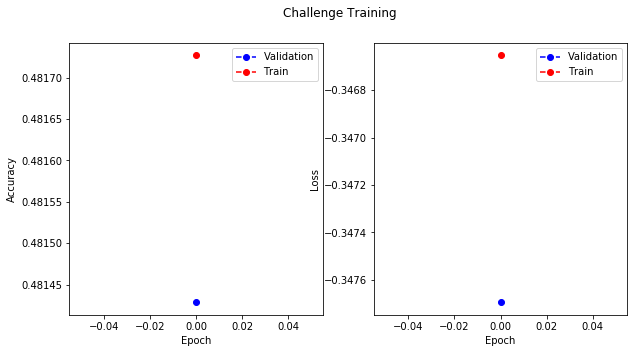

class: 0 total predicted: 13797
total actual: 9582
accuracy: 0.4470537073276799
class: 1 total predicted: 8603
total actual: 12818
accuracy: 0.6031616877833313
Epoch 1
	Validation Loss: -0.37011382704030626
	Validation Accuracy: 0.5070089285714285
	Train Loss: -0.37111541907468926
	Train Accuracy: 0.5091286829513977
class: 0 total predicted: 13397
total actual: 9582
accuracy: 0.4464432335597522
class: 1 total predicted: 9003
total actual: 12818
accuracy: 0.6000222148172831
Epoch 2
	Validation Loss: -0.3706202505759852
	Validation Accuracy: 0.5081696428571428
	Train Loss: -0.37281260263531063
	Train Accuracy: 0.5188239738101234
class: 0 total predicted: 12956
total actual: 9582
accuracy: 0.45044766903365235
class: 1 total predicted: 9444
total actual: 12818
accuracy: 0.6033460398136383
Epoch 3
	Validation Loss: -0.3709694250980482
	Validation Accuracy: 0.5149107142857143
	Train Loss: -0.3746872342401687
	Train Accuracy: 0.5296682195920424
class: 0 total predicted: 12602
total actual: 95

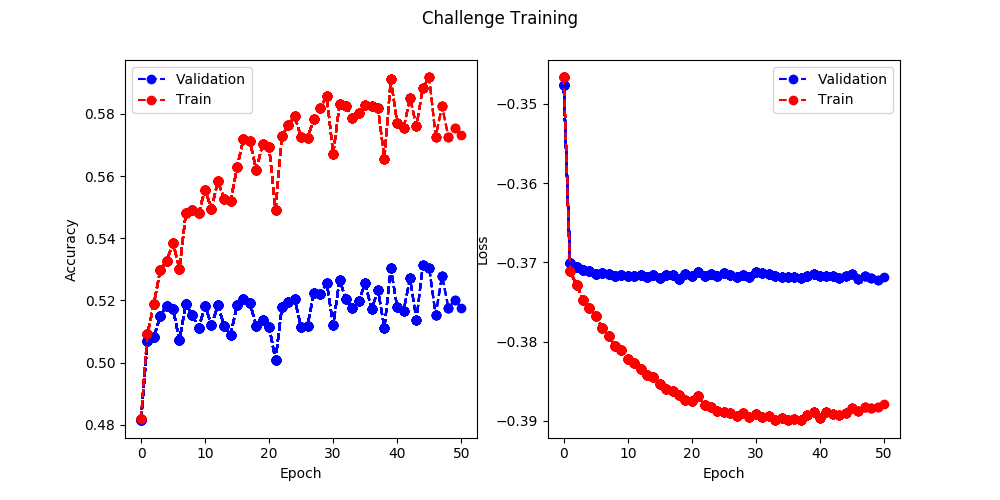

In [0]:

    
    

if __name__ == '__main__':
    tr_loader, va_loader,S,D,H,W, weight = get_train_val_test_loaders(
        num_classes=config('challenge.num_classes'))
    print(D,H,W)
    train(tr_loader, va_loader,S,D,H,W, weight)
    